In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import sys
sys.path.append("/Users/carlosnavarrete/Documents/Repos/PolaPy")

from polapy.competitiveness import election_competitiveness as competitiveness
from polapy.polarization import election_polarization as polarization, esteban_ray

In [2]:
country, year, election, aggregation = "Canada", 2021, "federal", "state"
# country, year, election, aggregation = "France", 2022, "first_round", "department_id"

input_df_location = pd.read_csv(f"../data_output/{country}/{year}_{election}_location.csv.gz", compression="gzip")
input_df = pd.read_csv(f"../data_output/{country}/{year}_{election}.csv.gz")
input_df = pd.merge(input_df, input_df_location[["polling_id", aggregation]])
if country == "France":
    input_df = input_df[~input_df[aggregation].astype(str).str.contains("Z")]

if "flag_candidates" in list(input_df):
    input_df = input_df[input_df["flag_candidates"] == 1]

input_df.head()

,polling_id,candidate,value,rate,rank,party,state
0,10001- 1-Freshwater,Carolyn Davis,13,0.130000,3,NDP-New Democratic Party,Newfoundland and Labrador
1,10001- 10-Carbonear,Carolyn Davis,6,0.069767,3,NDP-New Democratic Party,Newfoundland and Labrador
2,10001- 100-Conception Bay South,Carolyn Davis,19,0.223529,3,NDP-New Democratic Party,Newfoundland and Labrador
3,10001- 101-Conception Bay South,Carolyn Davis,50,0.273224,3,NDP-New Democratic Party,Newfoundland and Labrador
4,10001- 102-Conception Bay South,Carolyn Davis,42,0.234637,3,NDP-New Democratic Party,Newfoundland and Labrador


In [3]:
candidates = input_df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).reset_index()
candidates["cumulative"] = candidates["value"].cumsum() / candidates["value"].sum()
candidates["N_candidates"] = range(1, candidates.shape[0] + 1)

candidates["year"] = year
candidates.to_csv(f"../data_robustness/{country}/cumulative_{year}.csv", index=False)
candidates

,candidate,value,cumulative,N_candidates,year
0,Mike Lake,48340,0.002837,1,2021
1,John Barlow,44456,0.005446,2,2021
2,Tom Kmiec,44411,0.008052,3,2021
3,Blake Richards,43677,0.010615,4,2021
4,Damien Kurek,41819,0.013069,5,2021
...,...,...,...,...,...
2007,Ryan Huard,14,0.999998,2008,2021
2008,Eliana Rosenblum,13,0.999999,2009,2021
2009,Manon Lili Desbiens,11,0.999999,2010,2021
2010,Conrad Lukawski,7,1.000000,2011,2021


In [4]:
output = []

n_total = min(candidates.shape[0] + 1, 16)
for N_candidates in set(list(range(2, n_total)) + [candidates.shape[0]]):
    cnd = candidates.head(N_candidates)["candidate"].unique()

    df = input_df[input_df["candidate"].isin(cnd)].copy()
    df_frag = input_df[~input_df["candidate"].isin(cnd)].copy()
    df_frag["candidate"] = "OTHER"
    df = pd.concat([df, df_frag])

    tt = df.groupby([aggregation, "polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    for idx, data in tt.groupby(aggregation):
        within, ag = polarization(data, unit="polling_id", votes="value")
        between, ag = competitiveness(data, unit="polling_id", votes="value")
        output.append({
            aggregation: idx,
            "ed": within,
            "ec": between,
            "N_candidates": N_candidates
        })

output_df = pd.DataFrame(output)
output_df["year"] = year
output_df.to_csv(f"../data_robustness/{country}/candidates_{year}.csv", index=False)
output_df.head()

/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not

,state,ed,ec,N_candidates,year
0,Alberta,0.649724,0.228982,2,2021
1,British Columbia,0.000000,0.000000,2,2021
2,Manitoba,0.000000,0.000000,2,2021
3,New Brunswick,0.000000,0.000000,2,2021
4,Newfoundland and Labrador,0.000000,0.000000,2,2021


In [5]:
output_df = pd.DataFrame(output)
output_df["year"] = year
output_df.to_csv(f"../data_robustness/{country}/candidates_{year}.csv", index=False)
output_df.head()

,state,ed,ec,N_candidates,year
0,Alberta,0.649724,0.228982,2,2021
1,British Columbia,0.000000,0.000000,2,2021
2,Manitoba,0.000000,0.000000,2,2021
3,New Brunswick,0.000000,0.000000,2,2021
4,Newfoundland and Labrador,0.000000,0.000000,2,2021


ValueError: Could not interpret value `ep_x` for `x`. An entry with this name does not appear in `data`.

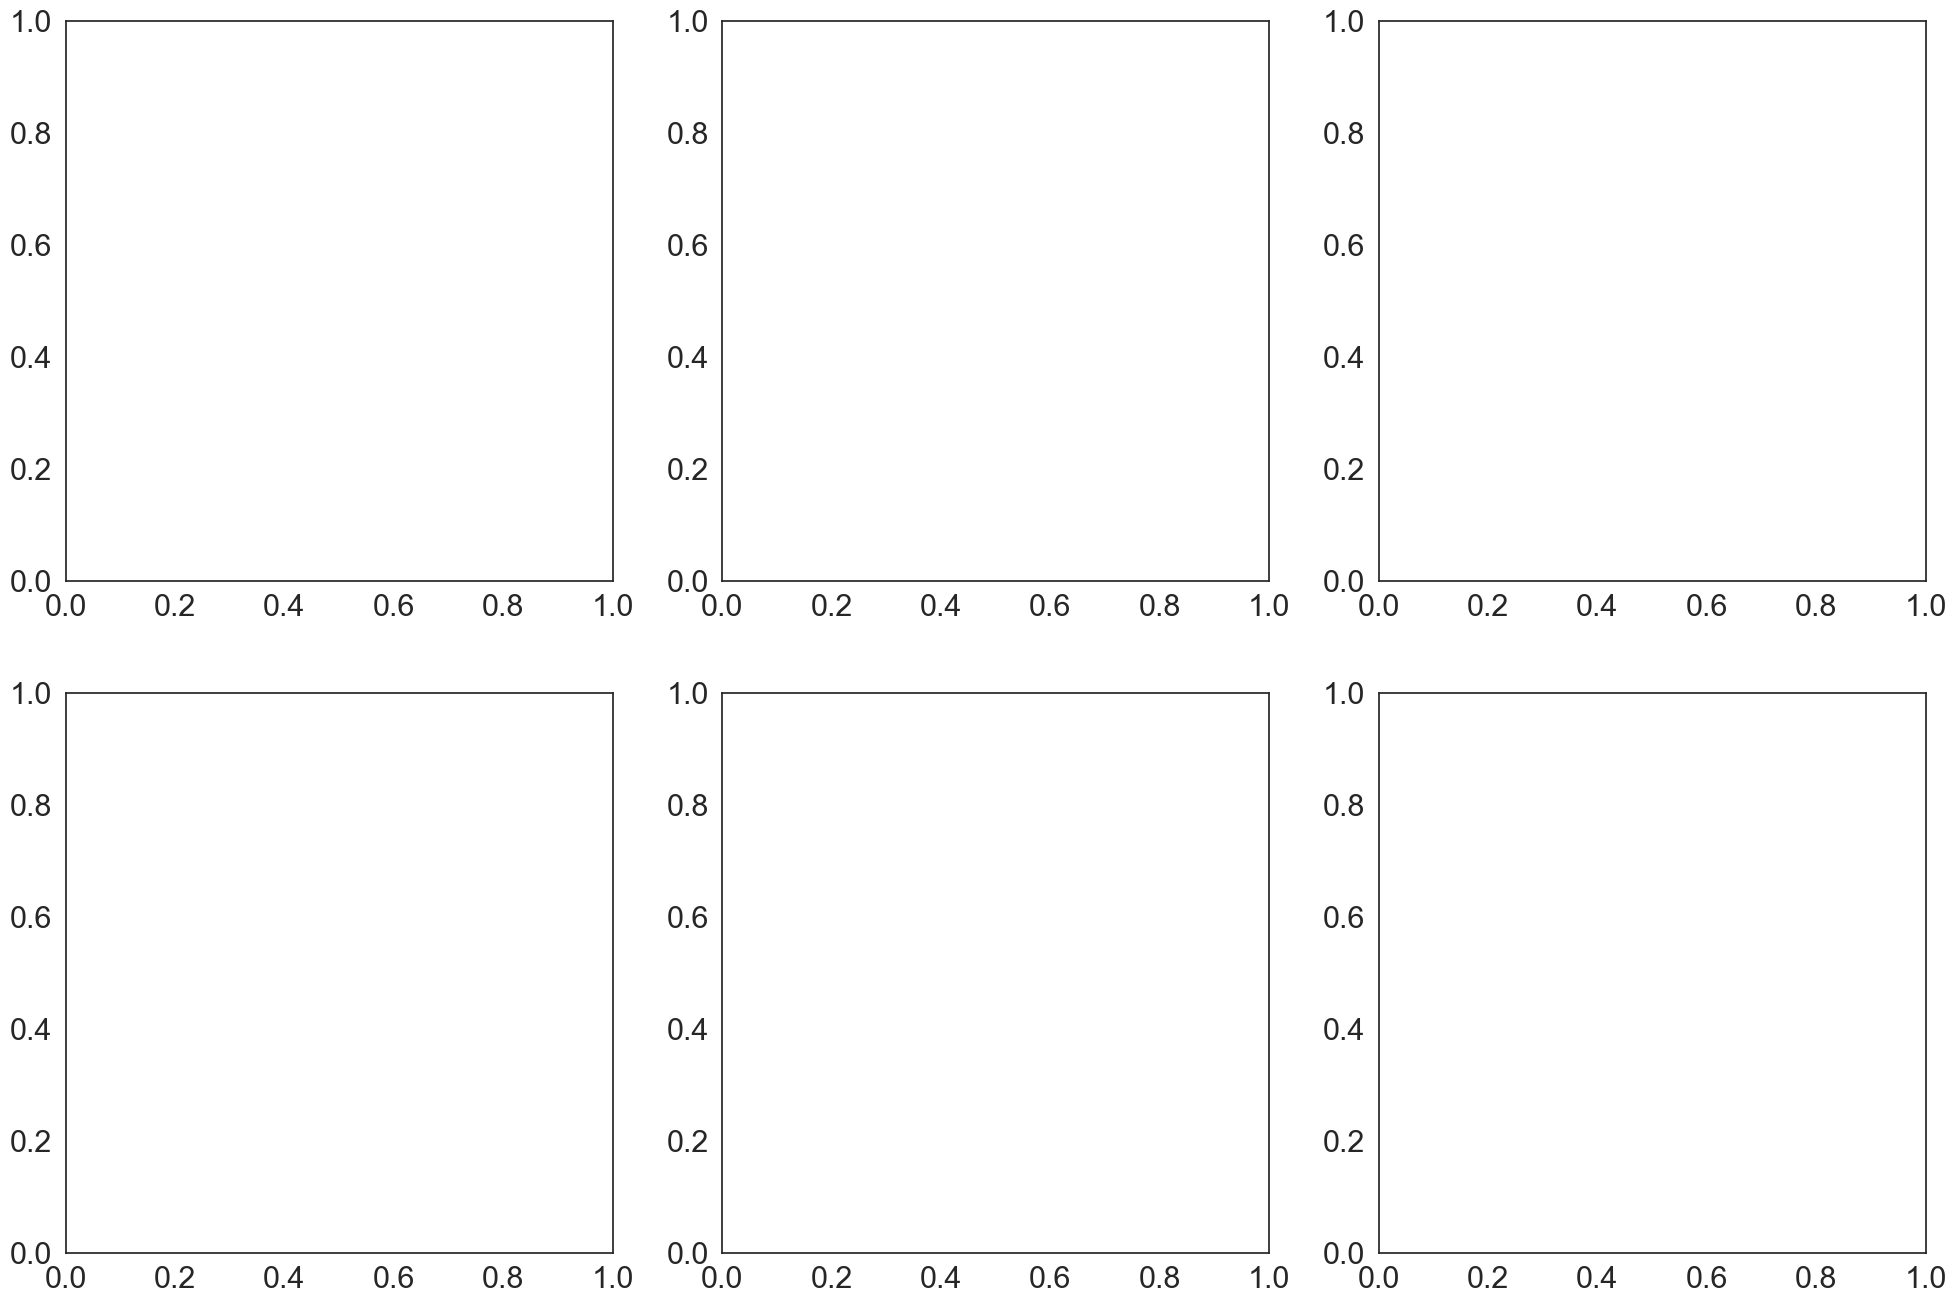

In [6]:
sns.set(font_scale=2, style="white")

if country in ["France", "Spain"]:
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
else:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

threshold = 10 + 1
if country not in ["France", "Spain"]:
    threshold = 7 + 1

metric = "ep"

for N_candidates in range(2, min(candidates.shape[0] + 1, threshold)): #10 + 1

    idx = N_candidates - 2
    ax = axs[int(idx/3), idx%3]

    data = pd.merge(
        output_df[output_df["N_candidates"] == N_candidates],
        output_df[output_df["N_candidates"] == candidates.shape[0]],
        on=aggregation
    )

    sns.scatterplot(
        x=f"{metric}_x",
        y=f"{metric}_y",
        data=data,
        # linewidth=0.25,
        s=85,
        zorder=2,
        color="blue",
        ax=ax
    )

    corr, pvalue = pearsonr(data[f"{metric}_x"], data[f"{metric}_y"])
    def corrfunc(corr, pvalue, ax):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return "ρ={:.3f}{}".format(corr, note)

    val = corrfunc(corr, pvalue, ax)
    ax.annotate(val, xy=(.05, .925), xycoords=ax.transAxes)

    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), zorder=1, color="red", lw=3, ls="--")

    ax.set_xlabel(f"{metric.upper()} ({N_candidates} candidates)")
    ax.set_ylabel(f"{metric.upper()} ({candidates.shape[0]} candidates)")
    ax.set_title(f"Percent of votes ({N_candidates} candidates)={round(candidates.iloc[idx + 1].cumulative * 100, 1)}%")

fig.tight_layout()

fig.savefig(f"../Figures_Appendix/Rb_multicandidate_{country}_{year}_{metric}.pdf")
